# Modelling version-1:

In this notebook, we will explore the one-model approach for `Wikipedia Web Traffic Forecasting` problem. In the one-model approach, we will create one generalizable model that can forecast the number of visits for all the pages present in the dataset. 

Import libraries

In [206]:
import pandas as pd
import numpy as np
import re 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

## Load the data:

In [207]:
PATH= "../data/train_1.csv"

In [208]:
df= pd.read_csv(PATH)

In [209]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


What are the columns in the dataset?

In [211]:
df.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

Other dataframes

In [212]:
PATH_2= "../data/key_1.csv"

In [213]:
key_df= pd.read_csv(PATH_2)

In [214]:
key_df.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [215]:
key_df.shape

(8703780, 2)

`key_df` contains the alpha-numeric ID for each Page and Date combination

In [216]:
# for example
key_df.iloc[1].Page

'!vote_en.wikipedia.org_all-access_all-agents_2017-01-02'

## Melt the dataframe:

First, drop rows with null values

In [217]:
df=df.dropna()

In [218]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


Take a sample from the dataframe

In [219]:
df_sample=df.sample(n=500, random_state=42)

In [220]:
df_sample.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
42042,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,4261.0,3872.0,3896.0,4270.0,3973.0,4300.0,4115.0,4028.0,3846.0,...,4437.0,3676.0,3226.0,3291.0,3836.0,4008.0,4092.0,3764.0,3719.0,3477.0
99800,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",291.0,347.0,335.0,305.0,283.0,270.0,302.0,327.0,303.0,...,421.0,391.0,528.0,418.0,403.0,356.0,379.0,388.0,365.0,243.0
53520,Dr_House_fr.wikipedia.org_mobile-web_all-agents,304.0,264.0,417.0,230.0,1002.0,406.0,318.0,321.0,345.0,...,450.0,442.0,335.0,373.0,914.0,728.0,961.0,1648.0,501.0,500.0
80024,File:Penny_black.jpg_commons.wikimedia.org_mob...,0.0,1.0,5.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0
106799,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,121.0,107.0,107.0,117.0,107.0,111.0,114.0,105.0,105.0,...,339.0,387.0,178.0,179.0,339.0,330.0,387.0,342.0,524.0,218.0


Now melt the dataframe

In [221]:
melted= df_sample.melt(id_vars='Page',var_name='Date' , value_name= 'Visits')

Let's check out the melted dataframe

In [222]:
melted.head(10)

,Page,Date,Visits
0,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,2015-07-01,4261.0
1,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",2015-07-01,291.0
2,Dr_House_fr.wikipedia.org_mobile-web_all-agents,2015-07-01,304.0
3,File:Penny_black.jpg_commons.wikimedia.org_mob...,2015-07-01,0.0
4,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,2015-07-01,121.0
5,Steyr_(Traktorenhersteller)_de.wikipedia.org_d...,2015-07-01,58.0
6,Category:Nude_in_photography_commons.wikimedia...,2015-07-01,98.0
7,張善為_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
8,Bahlika_en.wikipedia.org_all-access_all-agents,2015-07-01,11.0
9,Ronaldinho_es.wikipedia.org_desktop_all-agents,2015-07-01,2804.0


## Splitting the data:

Split the data into training and validation set

In [223]:
melted['DateTime'] = pd.to_datetime(melted['Date'])

In [224]:
melted.Date.min(), melted.Date.max()

('2015-07-01', '2016-12-31')

In [225]:
earliest_date=melted.DateTime.min()
melted['time_step'] = (melted['DateTime'] - earliest_date).dt.days

In [226]:
melted.tail()

,Page,Date,Visits,DateTime,time_step
274995,スタジオジブリ_ja.wikipedia.org_all-access_all-agents,2016-12-31,1125.0,2016-12-31,549
274996,Печенеги_ru.wikipedia.org_all-access_all-agents,2016-12-31,1509.0,2016-12-31,549
274997,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-12-31,5228.0,2016-12-31,549
274998,Decathlon_en.wikipedia.org_mobile-web_all-agents,2016-12-31,812.0,2016-12-31,549
274999,Saroo_Brierley_en.wikipedia.org_desktop_all-ag...,2016-12-31,2187.0,2016-12-31,549


Use the last month data as validation data

In [227]:
train=melted[melted['time_step']<490].copy()
valid=melted[melted['time_step']>=490].copy()

## Create 1-Step target:

In [228]:
train['visits_next_day']=train.groupby('Page')['Visits'].shift(-1)

In [229]:
train[train['Page']=='2NE1_zh.wikipedia.org_all-access_spider'].head()

,Page,Date,Visits,DateTime,time_step,visits_next_day


In [230]:
train[train['Page']=='2NE1_zh.wikipedia.org_all-access_spider'].tail()

,Page,Date,Visits,DateTime,time_step,visits_next_day


In [231]:
train=train.dropna()

In [232]:
train[train['Page']=='2NE1_zh.wikipedia.org_all-access_spider'].tail()

,Page,Date,Visits,DateTime,time_step,visits_next_day


Same with the validation dataframe

In [233]:
valid['visits_next_day']=valid.groupby('Page')['Visits'].shift(-1)

## Create Features:

### Lagging feature:

In [234]:
train['lag_1']=train.groupby('Page')['Visits'].shift(1)

In [235]:
valid['lag_1']=valid.groupby('Page')['Visits'].shift(1)

### Difference:

In [236]:
train['diff_1']=train.groupby('Page')['Visits'].diff(1)
valid['diff_1']=valid.groupby('Page')['Visits'].diff(1)

In [237]:
train[train['Page']=='2NE1_zh.wikipedia.org_all-access_spider'].tail()

,Page,Date,Visits,DateTime,time_step,visits_next_day,lag_1,diff_1


### Rolling Statistics:

In [238]:
train['mean_visits_4']= train.groupby('Page')["Visits"].rolling(4).mean().reset_index(level=0,drop=True)
valid['mean_visits_4']= valid.groupby('Page')["Visits"].rolling(4).mean().reset_index(level=0,drop=True)

In [239]:
train[train['Page']=='2NE1_zh.wikipedia.org_all-access_spider'].tail()

,Page,Date,Visits,DateTime,time_step,visits_next_day,lag_1,diff_1,mean_visits_4


### Date components: 

In [240]:
train['year']= train['DateTime'].dt.year
train['month']= train["DateTime"].dt.month
train['weekofyear']=train['DateTime'].dt.weekofyear

/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_58523/1421313403.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['weekofyear']=train['DateTime'].dt.weekofyear


In [241]:
valid['year']= valid['DateTime'].dt.year
valid['month']= valid["DateTime"].dt.month
valid['weekofyear']=valid['DateTime'].dt.weekofyear

/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_58523/3015978931.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  valid['weekofyear']=valid['DateTime'].dt.weekofyear


## Evaluation Metric:

In [242]:
# SMAPE Metric
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

## Baseline:

### Naive Approach:
Predict next day visits is going to be equal to be visits of today 

In [243]:
y_pred= train['Visits']
y_true= train['visits_next_day']

What is the baseline error for the 1-step prediction?

In [244]:
smape(y_true,y_pred)

33.09825874335084

In [245]:
y_pred= valid['Visits']
y_valid= valid['visits_next_day']

smape(y_valid,y_pred)

32.29814783239781

### Train the model:

In [246]:
train.head()

,Page,Date,Visits,DateTime,time_step,visits_next_day,lag_1,diff_1,mean_visits_4,year,month,weekofyear
0,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,2015-07-01,4261.0,2015-07-01,0,3872.0,NaN,NaN,NaN,2015,7,27
1,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",2015-07-01,291.0,2015-07-01,0,347.0,NaN,NaN,NaN,2015,7,27
2,Dr_House_fr.wikipedia.org_mobile-web_all-agents,2015-07-01,304.0,2015-07-01,0,264.0,NaN,NaN,NaN,2015,7,27
3,File:Penny_black.jpg_commons.wikimedia.org_mob...,2015-07-01,0.0,2015-07-01,0,1.0,NaN,NaN,NaN,2015,7,27
4,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,2015-07-01,121.0,2015-07-01,0,107.0,NaN,NaN,NaN,2015,7,27


In [247]:
feats=['Visits','lag_1','diff_1','mean_visits_4', 'month','weekofyear']

Basic imputation and preprocessing

In [248]:
imputer= SimpleImputer()

X_train= imputer.fit_transform(train[feats])
y_train= train['visits_next_day']

Let's train a basic model

In [249]:
model= RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

Check the performance

In [250]:
X_valid= imputer.transform(valid[feats])
y_valid= valid['visits_next_day']

y_pred= model.predict(X_valid)

In [251]:
smape(y_valid, y_pred)

39.310121024861175

In [252]:
def plot_predictions(actual, predicted, figsize= (15, 10) , title= "Predictions Plot"):
    
    plt.figure(figsize=figsize)
    actual = plt.plot(actual, color='blue', label='Actual')
    predicted = plt.plot(predicted, color='red', label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

Can we plot the predictions?

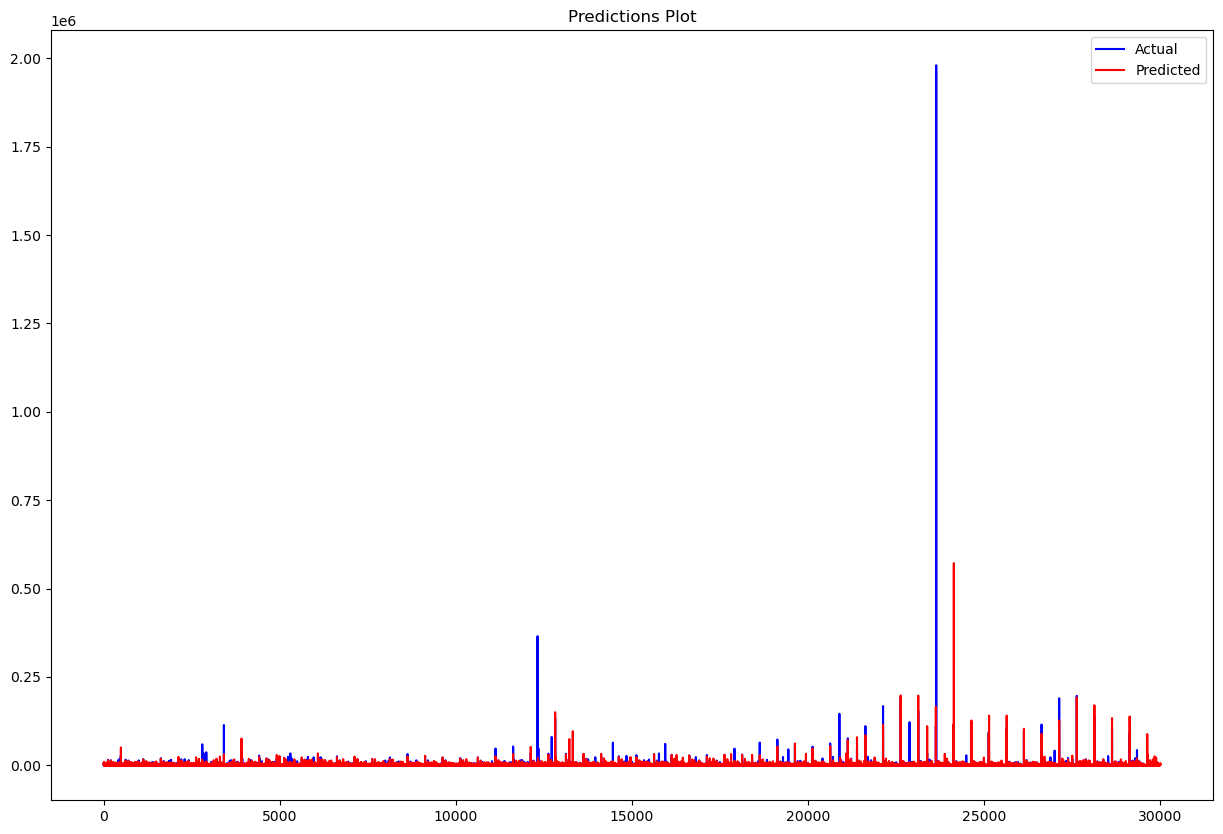

In [253]:
plot_predictions(actual= y_valid.values, predicted= y_pred)

## Creating 30-step target:

In [255]:
# train shift by one months
train['visits_next_month']=train.groupby('Page')['Visits'].shift(-30)
train=train.dropna(subset=['visits_next_day','visits_next_month'])

valid['visits_next_month']=valid.groupby('Page')['Visits'].shift(-30)

Let's see the dataset 

In [260]:
train[train['Page']=='Boy_George_en.wikipedia.org_mobile-web_all-agents'].tail(5)

,Page,Date,Visits,DateTime,time_step,visits_next_day,lag_1,diff_1,mean_visits_4,year,month,weekofyear,visits_next_month
227497,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-09-27,1256.0,2016-09-27,454,1105.0,3197.0,-1941.0,1808.5,2016,9,39,1963.0
227997,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-09-28,1105.0,2016-09-28,455,1144.0,1256.0,-151.0,1711.0,2016,9,39,1896.0
228497,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-09-29,1144.0,2016-09-29,456,1171.0,1105.0,39.0,1675.5,2016,9,39,2276.0
228997,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-09-30,1171.0,2016-09-30,457,1250.0,1144.0,27.0,1169.0,2016,9,39,2560.0
229497,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-10-01,1250.0,2016-10-01,458,1327.0,1171.0,79.0,1167.5,2016,10,39,1882.0


Create the model

In [263]:
imputer= SimpleImputer()

X_train= imputer.fit_transform(train[feats])
y_train= train[['visits_next_day','visits_next_month']]

In [264]:
model= RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

Check the performance

In [265]:
X_valid= imputer.transform(valid[feats])
y_valid= valid[['visits_next_day','visits_next_month']]

y_pred= model.predict(X_valid)

In [266]:
smape(y_valid, y_pred)

visits_next_day      38.273897
visits_next_month    35.879851
dtype: float64

Plot the predictions:

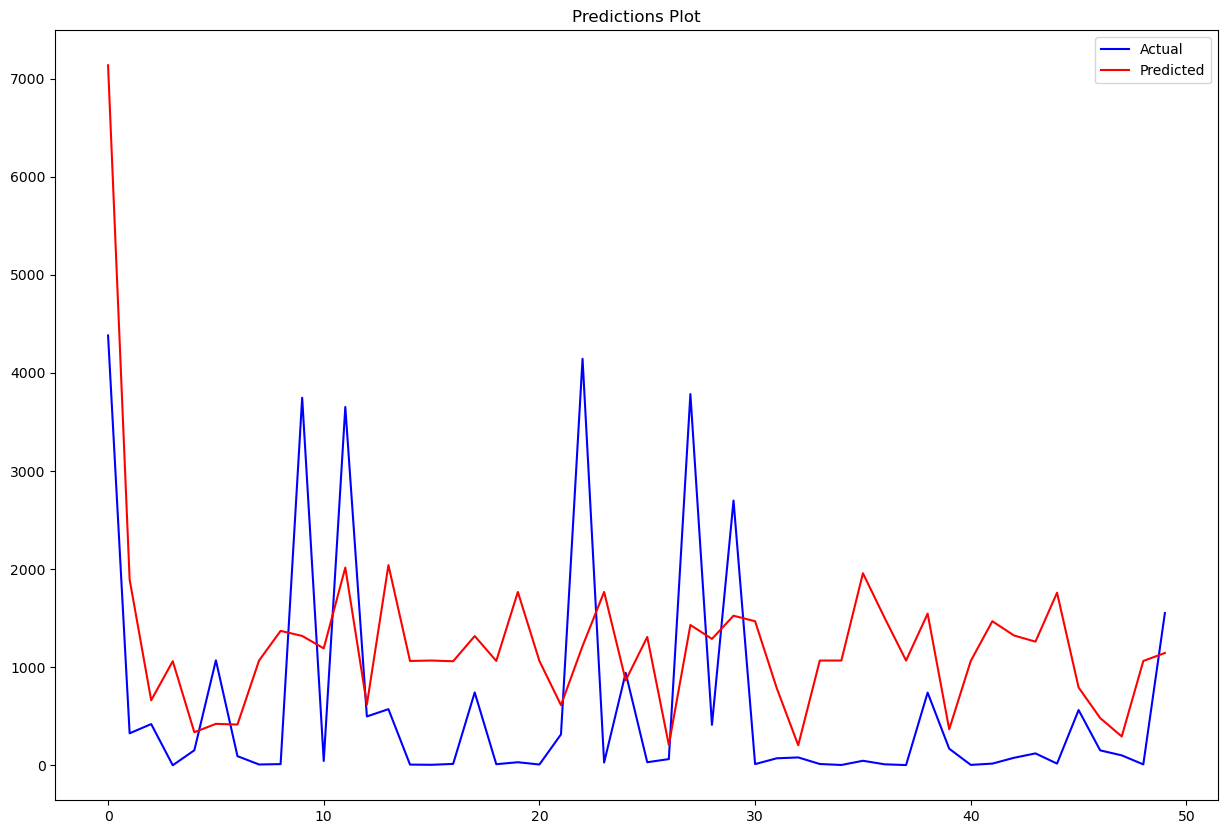

In [275]:
plot_predictions(actual= y_valid.values[:,1][:50], predicted= y_pred[:,1][:50])